In [1]:
## prerequisites

%pylab inline

import pandas as pd
from scipy import stats
import pymc3 as pm
from itertools import islice
import seaborn as sns
sns.set()

Populating the interactive namespace from numpy and matplotlib


# What is Monte Carlo Markov Chain?

* In Bayesian Modelling, we specify the **prior** and the **likelihood**
* The **unnormalized posterior** is easy to calculate, but the **real posterior** often has no analytical formula
* MCMC is a way to obtain **samples** proportional to the posterior
    1. MC: Markov Chain; do something in sequence, next sample only depends on the current 
    2. MC: Monte Carlo; do something stochastic (Monte Carlo is famous for it's casinos)

# 1 Introduction
---
### Example
As an introductory example, we observe two weights, 65kg, and 75kg.

We would like to learn something about the distribution of the weights.

![](../images/weights.png)

---
How do we model this?

In [2]:
# create some data
weights = np.array([65, 75])

# some variables we use for plot ting
mu = np.arange(60, 90, .1)
sigma = np.arange(0, 10, .1)[::-1]

real_x, real_y = mu, sigma[::-1]
dx = (real_x[1]-real_x[0])/2.
dy = (real_y[1]-real_y[0])/2.
extent = [real_x[0]-dx, real_x[-1]+dx, real_y[0]-dy, real_y[-1]+dy]

## 1.1 The likelihood

* This is the multiplication of the densities for the two samples
* The maximum likelihood estimate is at `mu=70` and `sigma=5`
* But, we also have the prior to take into account
* And, these are not just probabilities, but full densities

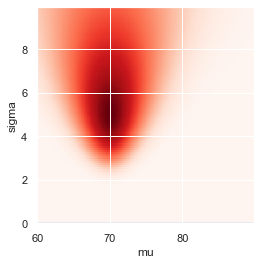

In [3]:
# calculate the likelihood for a grid
likelihood = stats.norm(mu, sigma.reshape(-1, 1)).pdf(65) * stats.norm(mu, sigma.reshape(-1, 1)).pdf(75)

# show in plot
plt.imshow(likelihood, aspect=len(mu) / len(sigma), extent = extent, cmap="Reds")
plt.xlabel('mu')
plt.ylabel('sigma');

## 1.2 The prior

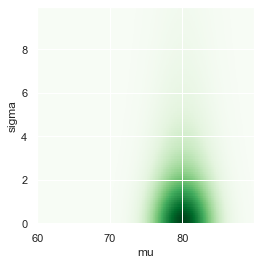

In [4]:
# calculate the prior for a grid
prior = stats.norm(80, 3).pdf(mu) * stats.cauchy(0, 2).pdf(sigma).reshape(-1, 1)

# show in plot
plt.imshow(prior, aspect=len(mu) / len(sigma), extent = extent, cmap="Greens", )
plt.xlabel('mu')
plt.ylabel('sigma');

## 1.3 The unnormalized posterior

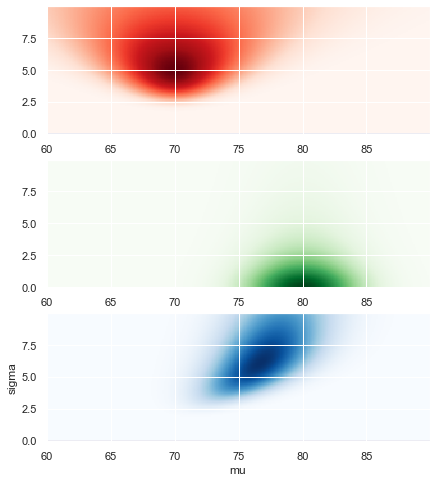

In [5]:
# calculate unnormalized posterior for the grid
unnormalized_posterior = prior * likelihood

# show likelihood, prior and posterior in plot
fig, axes = plt.subplots(3, figsize = (8, 8))

axes[0].imshow(likelihood, aspect=len(mu) / len(sigma) / 3, extent = extent, cmap="Reds")
axes[1].imshow(prior, aspect=len(mu) / len(sigma) / 3, extent = extent, cmap="Greens")
axes[2].imshow(unnormalized_posterior, aspect=len(mu) / len(sigma) / 3, extent = extent, cmap="Blues");
plt.xlabel('mu')
plt.ylabel('sigma');

## 1.4 Unnormalized posterior and samples obtained with `PyMC3`

* The samples are taken proportional to the (unnormalized) posterior density
* You can see the two parameters are not independent in the posterior. How? 

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]
Sampling chain 0, 0 divergences: 100%|██████████| 10500/10500 [00:02<00:00, 4507.00it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/davidwow/miniconda3/envs/pydata/lib/python3.8/site-packages/arviz/data/base.py:141: UserWarning: More chains (10000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


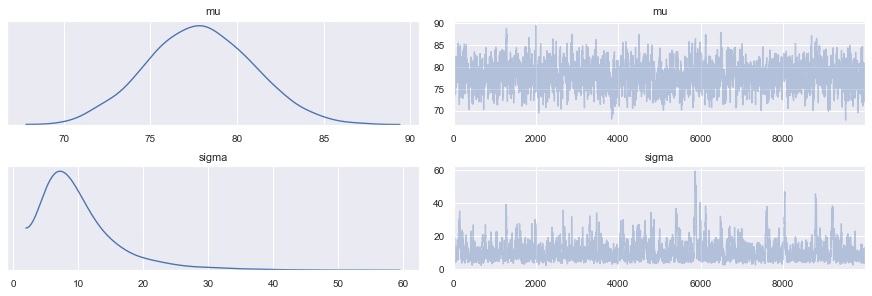

In [6]:
# sample from (unnormalized) posterior using pymc3

with pm.Model():
    mu = pm.Normal('mu', 80, 3)
    sigma = pm.Cauchy('sigma', 0, 2)
    pm.Normal('obs', mu, sigma, observed = [65, 75])
    trace = pm.sample(10000, start=dict(mu = 60, sigma = 1), chains=1, step=pm.Metropolis())

samples = pm.trace_to_dataframe(trace)
pm.traceplot(trace);

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


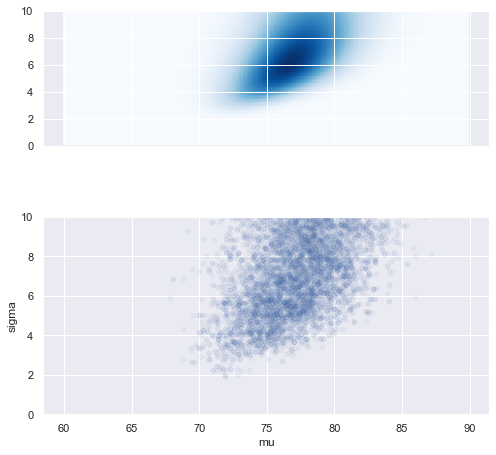

In [7]:
# show samples obtained by pymc3 togethter with unnormalized posterior
fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize = (8, 8))
axes[0].imshow(unnormalized_posterior, aspect=1, extent = extent, cmap="Blues")
samples.plot.scatter(x = "mu", y = "sigma", alpha = .05, ax = axes[1])
# sns.kdeplot(samples.mu, samples.sigma, ax = axes[2])
plt.ylim((0, 10));
plt.xlabel('mu')
plt.ylabel('sigma');

## 1.5 Conclusions

- Posterior is proportional to likelihood multiplied with prior.
- We 'showed' (with plots) that samples obtained with `pymc3` are from this distribution.
- `pymc3` can be used to approximate any posterior, even if we can not validate this with plots or math.
- We will come back to this example later. First we will look at MCMC itself...

# 2 MCMC
---

## 2.1 Visiting islands ([Statistical Rethinking](http://xcelab.net/rm/statistical-rethinking/))

* A king wants to visit islands proportional to number of people living on it
* For example, with two islands, with distribution `[1, 2]`, spend twice as much time on the second island as one the first
* He has many islands, **can only count the current and one other island**

![](./images/islands.png)

### Simple algorithm

* Count the number of inhabitants, stay that amount of days, then move to the next
* Below a sample path

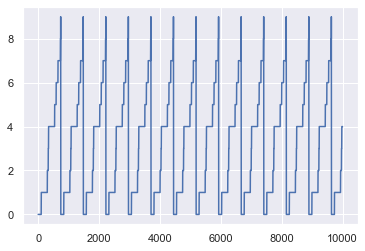

In [8]:
distribution = [100, 200, 30, 10, 200, 50, 60, 80, 10, 1]

def generate_path(distribution, start = 0):
    position = start
    while True:
        for _ in range(distribution[position]):
            yield position
        position = (position + 1) % len(distribution)

def sample_path(distribution, n = 1000): 
    return list(islice(generate_path(distribution), n))

pd.Series(sample_path(distribution, 10000)).plot();

### Simple algorithm

* Count the number of inhabitants, stay that amount of days, then move to the next
* After 1000 iterations, we have visited all the islands, but the approximation isn't very good yet

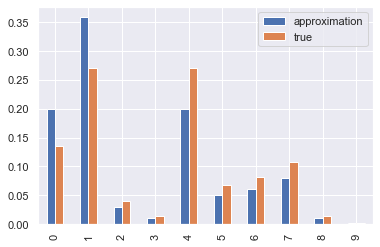

In [9]:
pd.Series(sample_path(distribution, 1000)).value_counts(normalize = True)\
    .reindex(list(range(len(distribution))))\
    .rename("approximation").to_frame().assign(
    true = np.array(distribution) / sum(distribution)
).plot.bar();

### Simple algorithm

* Below you see the approximation in action, the relative time spend in each island
* There are some biases, and in addition, things can be very bad if the number of days doesn't correspond well to the total number of inhabitants

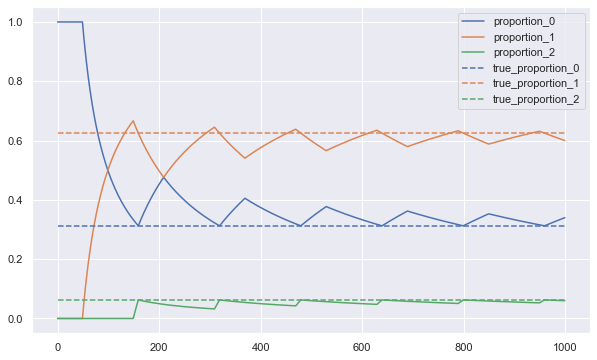

In [10]:
distribution = [50, 100, 10]
path = pd.Series(sample_path(distribution, 1000))

df = pd.DataFrame(index = path.index)
true_df = pd.DataFrame(index = path.index)
for i in range(len(distribution)):
    df["proportion_{}".format(i)] = path.expanding().apply(lambda x: (x == i).mean())
    true_df["true_proportion_{}".format(i)] = distribution[i] / sum(distribution)
    
ax = df.plot(figsize = (10, 6))
plt.gca().set_prop_cycle(None)
true_df.plot(ax = ax, style = '--');

## 2.2 Visiting islands with the Monte Carlo Markov Chain algorithm

* Pick a close island, go with probability $p$, otherwise stay for another day $$p = \min\left({1, \frac{\text{#proposal}}{\text{#current}}}\right)$$

![](./images/islands.png)

### Algorithm

* Pick left or right, go with probability $$p = \min\left({1, \frac{\text{#proposal}}{\text{#current}}}\right)$$
* Otherwise reject proposal

### Exercise: implement metropolis algorithm

* Loop, and in each loop
    * Make a proposal, which is left or right
    * Accept or reject the proposal based on the rejection rule
    * Store all states  
* Plot the distribution over the states
* Plot the path of the Markov Chain that you created

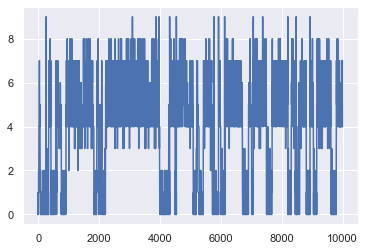

In [12]:
distribution = [100, 200, 30, 10, 200, 50, 60, 80, 10, 1]

def generate_path(distribution, start = 0):
    position = start
    while True:
        # TODO propose +1 -1
        proposal = (position + np.random.choice([1, -1])) % len(distribution)
        
        # TODO calculate probability of accepting
        acceptance_probability = distribution[proposal]/distribution[position]
        
        acceptance_probability = min(1, acceptance_probability)
        
        # TODO determine new position
        if stats.bernoulli(acceptance_probability).rvs():
            position = proposal
        
        
        yield position

def sample_path(distribution, n = 1000): 
    return list(islice(generate_path(distribution), n))

pd.Series(sample_path(distribution, 10000)).plot();

### Probabilistic algorithm

* The sample paths are different each time
* It is independent of absolute sizes

## Probabilistic algorithm

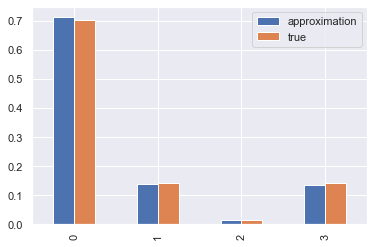

In [13]:
distribution = [500, 100, 10, 100]

pd.Series(sample_path(distribution, 1000)).value_counts(normalize = True)\
    .reindex(list(range(len(distribution))))\
    .rename("approximation").to_frame().assign(
    true = np.array(distribution) / sum(distribution)
).plot.bar()

## Probabilistic algorithm

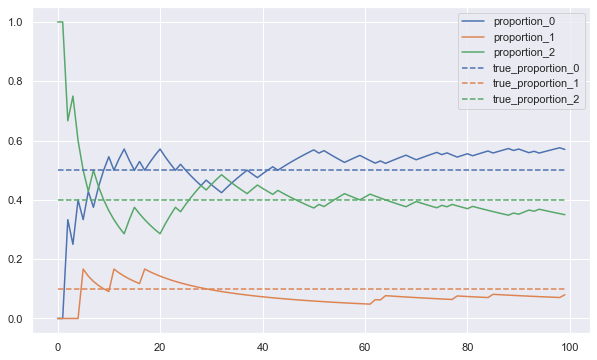

In [14]:
distribution = [500, 100, 400]
path = pd.Series(sample_path(distribution, 100))

df = pd.DataFrame(index = path.index)
true_df = pd.DataFrame(index = path.index)
for i in range(len(distribution)):
    df["proportion_{}".format(i)] = path.expanding().apply(lambda x: (x == i).mean())
    true_df["true_proportion_{}".format(i)] = distribution[i] / sum(distribution)

ax = df.plot(figsize = (10, 6))
plt.gca().set_prop_cycle(None)
true_df.plot(ax = ax, style = '--');

## MCMC in discrete case

* Multiply the likelihood with the prior to get an unnormalized posterior
* Sample a path with MCMC;
    * Proposals are next or previous
    * Accept according to relative density
* Count visits to each state to get proportional samples of the posterior

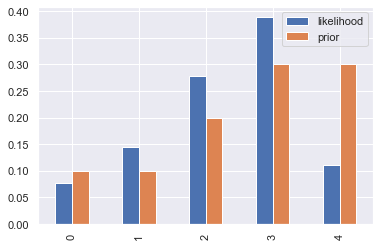

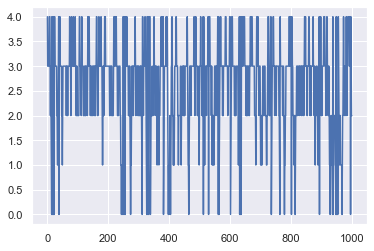

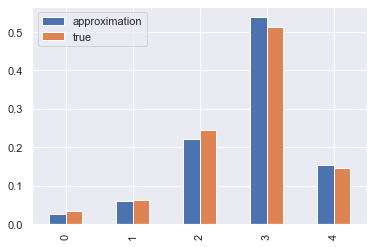

In [22]:
likelihood = np.array([.14, .26, .50, .70, .2])
prior = np.array([.1, .1, .2, .3, .3])

pd.DataFrame({
    "likelihood": likelihood / likelihood.sum(),
    "prior": prior / prior.sum(),
#     "proportion": likelihood * prior / sum(likelihood * prior)
}).plot.bar();

plt.show()

posterior_samples = sample_path(likelihood * prior)
pd.Series(posterior_samples).plot();

pd.Series(sample_path(likelihood * prior, 1000)).value_counts(normalize = True)\
    .reindex(list(range(len(likelihood * prior))))\
    .rename("approximation").to_frame().assign(
    true = np.array(likelihood * prior) / sum(likelihood * prior)
).plot.bar();

## MCMC in discrete case

* Multiply the likelihood with the prior to get an unnormalized posterior
* Sample a path with MCMC;
    * Proposals are next or previous
    * Accept according to relative density
* Count visits to each state to get proportional samples of the posterior

# Exercise

Remember the example at the start of this notebook? (it's copied below) We showed that `pymc3` sampled the analytical solution of the posterior well.

We are going to program an MCMC sampling routine that obtains a similar sample.

But first, let's reiterate the problem we were solving.

## MCMC in continuous case

* Sample a chain with MCMC
    * Get proposals via a random walk in parameter space (take steps with multivariate normal distribution)
    * Accept or reject according to relative density of likelihood times posterior
* These samples are proportional to the posterior distribution

![](./images/gauss_pdf.png)

### The data

In [15]:
# set the data
weights = np.array([65, 75])

### Prior, Likelihood and Posterior

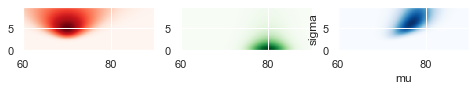

In [16]:
# some variables we use for plotting
mu = np.arange(60, 90, .1)
sigma = np.arange(0, 10, .1)[::-1]

real_x, real_y = mu, sigma[::-1]
dx = (real_x[1]-real_x[0])/2.
dy = (real_y[1]-real_y[0])/2.
extent = [real_x[0]-dx, real_x[-1]+dx, real_y[0]-dy, real_y[-1]+dy]

# actual calculations
likelihood = stats.norm(mu, sigma.reshape(-1, 1)).pdf(65) * stats.norm(mu, sigma.reshape(-1, 1)).pdf(75)
prior = stats.norm(80, 3).pdf(mu) * stats.cauchy(0, 2).pdf(sigma).reshape(-1, 1)
unnormalized_posterior = prior * likelihood


# more plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (8, 8))
axes[0].imshow(likelihood, aspect=len(mu) / len(sigma) / 3, extent = extent, cmap="Reds")
axes[1].imshow(prior, aspect=len(mu) / len(sigma) / 3, extent = extent, cmap="Greens")
axes[2].imshow(unnormalized_posterior, aspect=len(mu) / len(sigma) / 3, extent = extent, cmap="Blues")
plt.xlabel('mu')
plt.ylabel('sigma');

### With `pymc3`

In [17]:
with pm.Model():
    mu = pm.Normal('mu', 80, 3)
    sigma = pm.Cauchy('sigma', 0, 2)
    
    pm.Normal('obs', mu, sigma, observed = [65, 75])
    
    trace = pm.sample(10000, start=dict(mu = 60, sigma = 1), chains=1, step=pm.Metropolis())

samples = pm.trace_to_dataframe(trace)
pm.traceplot(trace);

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]
Sampling chain 0, 0 divergences: 100%|██████████| 10500/10500 [00:01<00:00, 5264.16it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/davidwow/miniconda3/envs/pydata/lib/python3.8/site-packages/arviz/data/base.py:141: UserWarning: More chains (10000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


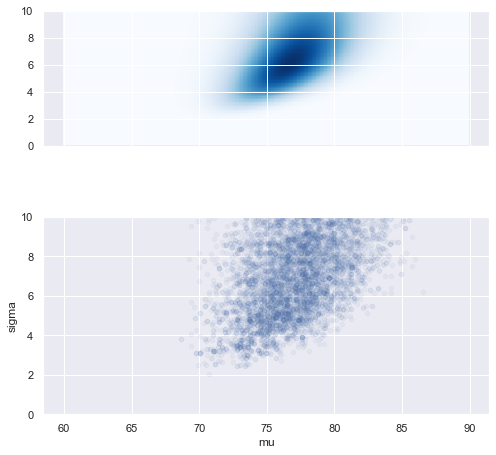

In [18]:
fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize = (8, 8))
axes[0].imshow(unnormalized_posterior, aspect=1, extent = extent, cmap="Blues")
samples.plot.scatter(x = "mu", y = "sigma", alpha = .05, ax = axes[1])
# sns.kdeplot(samples.mu, samples.sigma, ax = axes[2])
plt.ylim((0, 10))
plt.xlabel('mu')
plt.ylabel('sigma');

## Actual exercise

#### TIPS
---
- Do calculations in log space to avoid underflow issues
    - Multiplication becomes addition
    - Division becomes subtraction
    - Make sure to transform back at right time
- Don't worry too much about optimizing your code, unless you have time left

Pseudocode:
1. Initialize parameters $\theta_0$ and set $\theta_{\text{current}} = \theta_0$
3442. Iterate:
    1. Calculate $\text{Posterior}_{\text{current}}$
    2. Propose new theta $\theta_{\text{proposal}}$
    3. Calculate $\text{Posterior}_{\text{proposal}}$
    4. With probability $\min\left(\frac{\text{Posterior}_{\text{proposal}}}{\text{Posterior}_{\text{current}}},\ 1\right)$ set $\theta_{\text{current}} = \theta_{proposal}$
    5. Yield $\theta_{\text{current}}$

In [19]:
# with metropolis mcmc
def log_likelihood(mu, sigma, data):
    log_like = stats.norm(mu, sigma).logpdf(data).sum()  
    return log_like

def log_prior(mu, sigma):
    logprior = stats.norm(80, 3).logpdf(mu) + stats.cauchy(0, 2).logpdf(sigma)
    return logprior


def metropolis(starting_point, data):
    # initialize
    current_params = starting_point
    num_parameters = len(starting_point)
    
    
    # start your walk
    while True:
        # TODO calculate your current posterior
        current_log_posterior = log_likelihood(*current_params, data) + log_prior(*current_params)
              
        # TODO sample parameter step with unit gaussian around cuurent position
        proposal_params = current_params + np.random.normal(size=2)

        # TODO calculate posterior of the proposal
        proposal_log_posterior = log_likelihood(*proposal_params, data) + log_prior(*proposal_params)
  
        # TODO calculate the acceptance probability
        acceptance_probability = np.exp(proposal_log_posterior - current_log_posterior)
        acceptance_probability = min(1, acceptance_probability)
        
        # accept with that probability
        if stats.bernoulli(acceptance_probability).rvs():
            current_params = proposal_params
        
        yield current_params
    
mu_start = 60
sigma_start = 1
n_samples = 10000
starting_point = (mu_start, sigma_start)

metropolis_generator = metropolis(starting_point, weights)
samples_metrop = list(islice(metropolis_generator, n_samples))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


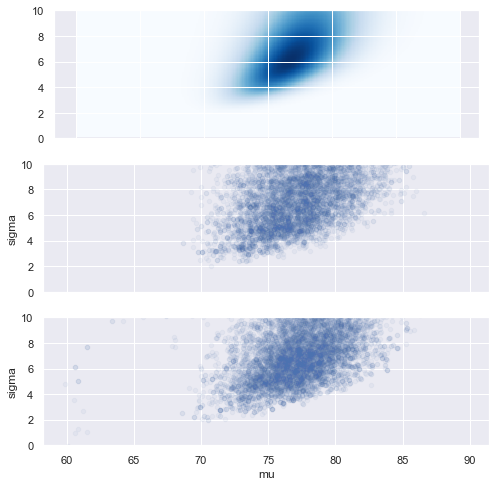

In [20]:
# this code will plot the posterior, samples from pymc3 and your own
fig, axes = plt.subplots(3, sharex=True, sharey=True, figsize = (8, 8))
axes[0].imshow(unnormalized_posterior, aspect=1, extent = extent, cmap="Blues")
samples.plot.scatter(x = "mu", y = "sigma", alpha = .05, ax = axes[1])
pd.DataFrame(samples_metrop, columns=['mu','sigma']).plot.scatter(x = "mu", y = "sigma", alpha = .05, ax = axes[2])
plt.ylim((0, 10));
plt.xlabel('mu')
plt.ylabel('sigma');

# Metropolis Algorithm

- Perturb parameters: $Q\left(\theta^{\prime};\ \theta\right)$ e.g. $\mathcal{N}\left(\theta,\ \sigma^2\right)$
- Accept with probability $\min \left(1, \frac{P\left(\theta^{\prime}|\mathcal{D}\right)}{P\left(\theta|\mathcal{D}\right)} \right)$
- Otherwise **keep old parameters**

### Conclusion MCMC in continuous case

* Sample a chain with MCMC
    * Get proposals via a random walk in parameter space (take steps with multivariate normal distribution)
    * Accept or reject according to relative density of likelihood times posterior
* These samples are proportional to the posterior distribution

## Hamiltonian Monte Carlo

* Works by simulating a skateboarder on the likelihood surface
* Needs to calculate gradients of likelihoods
* Allows sampling from complicated distributions
* Optimization of stepsizes and starting point is very important
* See the example at http://chi-feng.github.io/mcmc-demo/app.html#RandomWalkMH,banana

![](./images/skatepark.png)

## Overview of posterior approximations

* There are many methods for finding the posterior solution
* Roughly, the only method used to be analytical solutions, then computers made sampling possible
* Variational inference is a recent development which makes inference more scalable
* There is a lot of development on the intersection between Bayesian statistics and Neural Nets

Method | How | Since | Tools
--- | --- | --- | ---
Analytical methods | Update the conjugate priors | <1900 | Knowledge
Grid approximation | Calculate likelihoods on grid and interpolate | <1900 | `numpy`
Metropolis and Gibbs | Random walk over parameter space | ~1950 | `stan`, `pymc3` 
Hamiltonian Monte Carlo | Improved random walk using physics simulation | ~2000 | `stan`, `pymc3`
Variational Inference | Approximate posterior with kernels | ~2010 | `edward`, `stan`, `pymc3`

### Conclusion

- We can interpret the traceplots now to say something about the quality of our model and the sample
- Models can be manipulated by turning cerain knobs
- By generating data we can 'debug' models easily